# Graph Neuronal Networks

In [18]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [19]:
import torch
import torch.nn.functional as F # Programación funcional para nn en torch
from torch_geometric.nn import GCNConv # Convolutional GNN
import pandas as pd

In [20]:
# Datos
edges = pd.read_csv("../data/raw/musae_git_edges.csv")
features = pd.read_csv("../data/raw/musae_git_features.csv")
target = pd.read_csv("../data/raw/musae_git_target.csv")

##  Convert Data to PyTorch Tensors

### Convert edge df to edge index tensor

In [21]:
# Convert edge list to tensor (transpose to match PyG format)
edge_index = torch.tensor(edges.values.T, dtype=torch.long)
# If your graph is undirected, make sure to add both directions:
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

### Convert features to a Dense Tensor

Creamos un multi-hot enconding con los features, de forma que a cada nodo le corresponda un vector de tamaño 4005 (el número de features diferentes) formado por 1 en las features que tenga el nodo y 0 en las demás

In [22]:
# Assuming features is stored as: [node, feature_id]
num_nodes = target.shape[0]  # Total number of nodes
num_features = features["feature"].nunique()  # Feature count 

# Create a one-hot encoded tensor
x = torch.zeros((num_nodes, num_features), dtype=torch.float)

# Fill the feature matrix
for row in features.itertuples(index=False):
    node_id, feature_id = row  # Assuming (node, feature) pairs
    x[node_id, feature_id] = 1

### Convert target to a Label Tensor
Convert target to a Label Tensor

In [23]:
y = torch.tensor(target["ml_target"].values, dtype=torch.long)

**Lo metemos todo en un objeto Data de torch_geometric**

Data is a container class used by PyTorch Geometric to store the graph structure. Data is a class from the torch_geometric.data module that holds the following components:
- x: A tensor of node features. Shape: [num_nodes, num_features]
- edge_index: A tensor of graph edges (connectivity). Shape: [2, num_edges], where each column represents an edge between two nodes.
- y: A tensor of labels for each node (for node classification) or graph (for graph classification).
- Additional Attributes: You can also add other graph-related data like masks for training/validation, edge features, node-level attributes, and so on.


In [24]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
x = x.to(device)  
edge_index = data.edge_index.to(device)  

### Particion entrenamiento, validacion, test

In [26]:
# Split nodes into train, validation, and test sets
num_nodes = data.x.size(0)  # Number of nodes in the graph
indices = torch.randperm(num_nodes)  # Randomly permute node indices

# Define the split proportions
train_size = int(0.6 * num_nodes)  # 60% for training
val_size = int(0.2 * num_nodes)  # 20% for validation
test_size = num_nodes - train_size - val_size  # Remaining 20% for testing

train_mask = indices[:train_size]
val_mask = indices[train_size:train_size + val_size]
test_mask = indices[train_size + val_size:]

# Create boolean masks for each set
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_mask] = 1  # Set training nodes to 1
data.val_mask[val_mask] = 1  # Set validation nodes to 1
data.test_mask[test_mask] = 1  # Set test nodes to 1

## Definimos la GNN

In [27]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)  

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  
        x = F.dropout(x, training=self.training)  
        x = self.conv2(x, edge_index)  
        return x # Usaremos cross_entropy que toma los raw logits

In [28]:
model = GCN(hidden_channels=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Optimizador

In [29]:
def train():
    model.train()
    optimizer.zero_grad() # Inicializar los gradientes a 0
    out = model(x, data.edge_index) # data.edge_index: adeyacencias

    # # Debugging: Check output shape and label range
    # print("Output shape: ", out.shape)
    # print("Labels shape: ", data.y[data.train_mask].shape)

    # # Make sure the target labels are within the valid range
    # print("Max label in train: ", data.y[data.train_mask].max())
    # print("Min label in train: ", data.y[data.train_mask].min())

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    # print(f"Loss: {loss.item()}")

    loss.backward() # Retropropagación
    optimizer.step() # Actualizar los pesos
    return loss.item()

def validation():
    model.eval()
    out = model(x, data.edge_index)
    pred = out.argmax(dim=1) 
    val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    return val_acc, train_acc

In [30]:
# Example of moving data to the device
x = x.to(device)
edge_index = data.edge_index.to(device)
data.y = data.y.to(device)
data.train_mask = data.train_mask.to(device)
data.val_mask = data.val_mask.to(device)
data.test_mask = data.test_mask.to(device)

In [31]:
train_acc_list =[]
val_acc_list = []

for epoch in range(1, 400):
    loss = train()
    res = validation()
    val_acc, train_acc = res
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    print(f'Epoch: {epoch:03d}, Training Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch: 001, Training Loss: 0.6834, Train Accuracy: 0.7408, Val Accuracy: 0.7326
Epoch: 002, Training Loss: 0.5346, Train Accuracy: 0.7410, Val Accuracy: 0.7326
Epoch: 003, Training Loss: 0.5251, Train Accuracy: 0.7417, Val Accuracy: 0.7332
Epoch: 004, Training Loss: 0.4895, Train Accuracy: 0.7458, Val Accuracy: 0.7375
Epoch: 005, Training Loss: 0.4587, Train Accuracy: 0.7686, Val Accuracy: 0.7610
Epoch: 006, Training Loss: 0.4351, Train Accuracy: 0.8027, Val Accuracy: 0.7954
Epoch: 007, Training Loss: 0.4157, Train Accuracy: 0.8191, Val Accuracy: 0.8118
Epoch: 008, Training Loss: 0.4011, Train Accuracy: 0.8306, Val Accuracy: 0.8237
Epoch: 009, Training Loss: 0.3883, Train Accuracy: 0.8434, Val Accuracy: 0.8367
Epoch: 010, Training Loss: 0.3754, Train Accuracy: 0.8548, Val Accuracy: 0.8477
Epoch: 011, Training Loss: 0.3612, Train Accuracy: 0.8624, Val Accuracy: 0.8513
Epoch: 012, Training Loss: 0.3516, Train Accuracy: 0.8660, Val Accuracy: 0.8554
Epoch: 013, Training Loss: 0.3403, Train

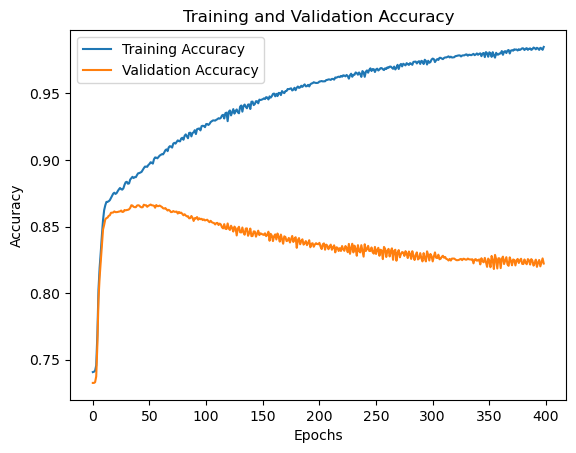

In [32]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(train_acc_list, label='Training Accuracy')

# Plot validation accuracy
plt.plot(val_acc_list, label='Validation Accuracy')

# Add title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()

In [36]:
torch.tensor(val_acc_list).argmax()

tensor(51)

Juntamos los datos de entrenamiento y validación para reentrenar el modelo en 51 epocas y evaluamos el rendimiento en test

In [ ]:
# Paso 1: Combinar los datos de entrenamiento y validación
data.train_mask = data.train_mask | data.val_mask  # Usar la máscara de entrenamiento y validación combinadas

# Paso 2: Reentrenar el modelo con el conjunto de entrenamiento + validación
model.train()  # Establecer el modelo en modo de entrenamiento
optimizer.zero_grad()  # Reiniciar los gradientes

for epoch in range(1, 51):
    optimizer.zero_grad()
    out = model(x, data.edge_index)  # Obtener las predicciones del modelo

    # Calculamos la pérdida para todo el conjunto de entrenamiento y validación combinados
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()  # Propagación hacia atrás
    optimizer.step()  # Actualizar los parámetros del modelo

    if epoch % 10 == 0:  # Imprimir el progreso cada 10 épocas
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Paso 3: Evaluar el modelo en el conjunto de prueba
model.eval()  # Establecer el modelo en modo de evaluación
with torch.no_grad():  # Desactivar el cálculo de gradientes
    out = model(x, data.edge_index)  # Obtener las predicciones del modelo

    # Obtener las predicciones utilizando argmax
    pred = out.argmax(dim=1)

    # Evaluación en el conjunto de prueba
    test_acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f'Accuracy on Test Set: {test_acc}')


Epoch 10, Loss: 0.09839155524969101
Epoch 20, Loss: 0.09349830448627472
Epoch 30, Loss: 0.09098667651414871
Epoch 40, Loss: 0.08813445270061493
Epoch 50, Loss: 0.08658021688461304
Accuracy on Test Set: 0.8388594164456233


In [41]:
pd.crosstab(pred.cpu(),data.test_mask.cpu())

col_0,False,True
row_0,,
0,22596,5747
1,7564,1793
